# Stock Forecasting Portfolio - Phase 2: Data Science (DS)

## Objective
Train and compare 3 models for Top 10 Global AI Stocks:
1. **XGBoost** (Gradient Boosting)
2. **LSTM** (Deep Learning - PyTorch)
3. **N-BEATS** (Advanced DL - NeuralForecast)

## Hardware
- **GPU**: RTX 3060 (6GB VRAM)
- **Data**: 10 Years (Max available)

## 0. Install Dependencies (Run Once)

In [6]:
# Install missing libraries
!pip install neuralforecast statsforecast prophet statsmodels
!pip install chronos-forecasting --no-cache-dir
!pip install yfinance --upgrade --no-cache-dir

In [ ]:
# Uninstall library yang konflik
#!pip uninstall -y torchvision torchmetrics

# Install ulang dengan versi yang kompatibel untuk torch 2.5.1
#!pip install torchvision==0.20.1 torchmetrics==1.5.2

## 1. Setup & Login

In [ ]:
import wandb
import mlflow
import torch
import torch.nn as nn
import pandas as pd
import yfinance as yf
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS

# Initialize MLOps
wandb.login(key="Your_WandB_API_KEY")
MLFLOW_TRACKING_URI = "http://34.59.127.37:5000/"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
print(f"✅ MLFlow Tracking URI: {mlflow.get_tracking_uri()}")

# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Using Device: {device}")

# Global Results Storage
results = []

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


✅ MLFlow Tracking URI: http://34.59.127.37:5000/
✅ Using Device: cpu


## 2. Data Preparation

In [8]:
tickers = ['NVDA', 'MSFT', 'GOOGL', 'META', 'AMZN', 'AMD', 'TSM', 'AVGO', 'PLTR', 'TSLA']

def get_ready_data(ticker):
    print(f"📥 Fetching {ticker}...")
    df = yf.download(ticker, period='10y', interval='1d', auto_adjust=True, progress=False)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    if df.empty: return None

    # Tech Indicators
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['MA50'] = df['Close'].rolling(window=50).mean()
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    df['Lag1'] = df['Close'].shift(1)
    df['Lag2'] = df['Close'].shift(2)
    df.dropna(inplace=True)
    return df
get_ready_data('NVDA')

📥 Fetching NVDA...


Price,Close,High,Low,Open,Volume,MA20,MA50,RSI,Lag1,Lag2
Date,,,,,,,,,,
2016-03-11,0.788792,0.789037,0.777776,0.787078,277400000,0.759235,0.724939,59.781827,0.775572,0.776796
2016-03-14,0.790751,0.793933,0.781448,0.785120,190312000,0.767391,0.724465,59.784602,0.788792,0.775572
2016-03-15,0.786834,0.791730,0.772879,0.786589,226216000,0.773815,0.724122,55.305970,0.790751,0.788792
2016-03-16,0.810336,0.813029,0.777286,0.780958,363644000,0.780597,0.724537,63.272921,0.786834,0.790751
2016-03-17,0.803481,0.811315,0.792464,0.807398,353680000,0.784134,0.724561,62.388805,0.810336,0.786834
...,...,...,...,...,...,...,...,...,...,...
2025-12-22,183.690002,184.160004,182.350006,183.919998,129064400,179.916998,185.654470,52.632936,180.990005,174.139999
2025-12-23,189.210007,189.330002,182.899994,182.970001,174873600,180.250506,185.672480,60.424339,183.690002,180.990005
2025-12-24,188.610001,188.910004,186.589996,187.940002,65528500,180.790501,185.844280,56.082804,189.210007,183.690002


## 3. Model Definitions

In [9]:
# LSTM Architecture
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length-1):
        xs.append(data[i:(i+seq_length)])
        ys.append(data[i+seq_length])
    return np.array(xs), np.array(ys)

In [10]:
# Create or Set MLFlow Experiment
experiment_name = "stock-forecasting-ai"
try:
    experiment_id = mlflow.create_experiment(experiment_name)
    print(f"✅ Created new experiment: {experiment_name} (ID: {experiment_id})")
except Exception as e:
    # Experiment already exists, get its ID
    experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id
    print(f"✅ Using existing experiment: {experiment_name} (ID: {experiment_id})")

mlflow.set_experiment(experiment_name)

✅ Using existing experiment: stock-forecasting-ai (ID: 4)


<Experiment: artifact_location='gs://mlflow-artifacts-ba-portfolio/4', creation_time=1767031241885, experiment_id='4', last_update_time=1767031241885, lifecycle_stage='active', name='stock-forecasting-ai', tags={'mlflow.experimentKind': 'custom_model_development'}>

## 4. Training Loop (All Models)

In [11]:

import xgboost as xgb
import torch
import torch.nn as nn
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
try:
    from chronos import ChronosPipeline
except ImportError:
    pass

import wandb
import mlflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def train_all_models(ticker):
    print(f"\n{'='*50}\n🎯 PROCESSING {ticker}\n{'='*50}")
    df = get_ready_data(ticker)
    if df is None: return
    
    # Train/Test Split (Time Series)
    train_size = int(len(df) * 0.8)
    train_df, test_df = df.iloc[:train_size], df.iloc[train_size:]
    features = ['MA20', 'MA50', 'RSI', 'Lag1', 'Lag2']
    target = 'Close'
    
    # Initialize metrics
    mae_xgb = mae_lstm = mae_nbeats = mae_arima = mae_prophet = mae_chronos = float('inf')
    rmse_xgb = rmse_lstm = rmse_nbeats = rmse_arima = rmse_prophet = rmse_chronos = float('inf')
    
    # ========== MODEL 1: XGBoost ==========
    run_xgb = wandb.init(project="stock-forecasting", name=f"{ticker}_XGBoost", reinit=True)
    try:
        model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5)
        model_xgb.fit(train_df[features], train_df[target])
        preds_xgb = model_xgb.predict(test_df[features])
        
        mae_xgb = mean_absolute_error(test_df[target], preds_xgb)
        rmse_xgb = np.sqrt(mean_squared_error(test_df[target], preds_xgb))
        wandb.log({"MAE": mae_xgb, "RMSE": rmse_xgb})
        print(f"✅ XGBoost → MAE: {mae_xgb:.2f}, RMSE: {rmse_xgb:.2f}")
        results.append({"Ticker": ticker, "Model": "XGBoost", "MAE": mae_xgb, "RMSE": rmse_xgb})
    except Exception as e:
        print(f"❌ XGBoost failed: {e}")
    run_xgb.finish()
    
    # ========== MODEL 2: LSTM ==========
    run_lstm = wandb.init(project="stock-forecasting", name=f"{ticker}_LSTM", reinit=True)
    try:
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(df[['Close']].values)
        SEQ_LEN = 60
        X_lstm, y_lstm = create_sequences(scaled_data, SEQ_LEN)
        
        train_size_lstm = int(len(X_lstm) * 0.8)
        X_train = torch.from_numpy(X_lstm[:train_size_lstm]).float().to(device)
        y_train = torch.from_numpy(y_lstm[:train_size_lstm]).float().to(device)
        X_test = torch.from_numpy(X_lstm[train_size_lstm:]).float().to(device)
        y_test = torch.from_numpy(y_lstm[train_size_lstm:]).float().to(device)
        
        model_lstm = LSTMModel(input_dim=1, hidden_dim=64, num_layers=2, output_dim=1).to(device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.001)
        
        for epoch in range(30):
            model_lstm.train()
            optimizer.zero_grad()
            outputs = model_lstm(X_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            optimizer.step()
        
        model_lstm.eval()
        with torch.no_grad():
            test_preds_scaled = model_lstm(X_test)
        test_preds = scaler.inverse_transform(test_preds_scaled.cpu().numpy())
        y_test_real = scaler.inverse_transform(y_test.cpu().numpy())
        
        mae_lstm = mean_absolute_error(y_test_real, test_preds)
        rmse_lstm = np.sqrt(mean_squared_error(y_test_real, test_preds))
        wandb.log({"MAE": mae_lstm, "RMSE": rmse_lstm})
        print(f"✅ LSTM → MAE: {mae_lstm:.2f}, RMSE: {rmse_lstm:.2f}")
        results.append({"Ticker": ticker, "Model": "LSTM", "MAE": mae_lstm, "RMSE": rmse_lstm})
    except Exception as e:
        print(f"❌ LSTM failed: {e}")
    run_lstm.finish()
    
    # ========== MODEL 3: N-BEATS ==========
    run_nbeats = wandb.init(project="stock-forecasting", name=f"{ticker}_NBEATS", reinit=True)
    try:
        nf_df = df.reset_index()[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})
        nf_df['unique_id'] = ticker
        nf_df = nf_df[['unique_id', 'ds', 'y']]
        
        horizon = 30
        models_nf = [NBEATS(input_size=60, h=horizon, max_steps=50)]
        nf = NeuralForecast(models=models_nf, freq='D')
        nf.fit(df=nf_df[:-horizon])
        forecast = nf.predict()
        
        actual = nf_df[-horizon:]['y'].values
        predicted = forecast['NBEATS'].values
        mae_nbeats = mean_absolute_error(actual, predicted)
        rmse_nbeats = np.sqrt(mean_squared_error(actual, predicted))
        wandb.log({"MAE": mae_nbeats, "RMSE": rmse_nbeats})
        print(f"✅ N-BEATS → MAE: {mae_nbeats:.2f}, RMSE: {rmse_nbeats:.2f}")
        results.append({"Ticker": ticker, "Model": "N-BEATS", "MAE": mae_nbeats, "RMSE": rmse_nbeats})
    except Exception as e:
        print(f"❌ N-BEATS failed: {e}")
    run_nbeats.finish()
    
    # ========== MODEL 4: ARIMA ==========
    run_arima = wandb.init(project="stock-forecasting", name=f"{ticker}_ARIMA", reinit=True)
    try:
        model_arima = ARIMA(train_df['Close'], order=(5,1,0))
        model_fit = model_arima.fit()
        preds_arima = model_fit.forecast(steps=len(test_df))
        
        mae_arima = mean_absolute_error(test_df['Close'], preds_arima)
        rmse_arima = np.sqrt(mean_squared_error(test_df['Close'], preds_arima))
        
        wandb.log({"MAE": mae_arima, "RMSE": rmse_arima})
        print(f"✅ ARIMA → MAE: {mae_arima:.2f}, RMSE: {rmse_arima:.2f}")
        results.append({"Ticker": ticker, "Model": "ARIMA", "MAE": mae_arima, "RMSE": rmse_arima})
    except Exception as e:
        print(f"❌ ARIMA failed: {e}")
    run_arima.finish()

    # ========== MODEL 5: PROPHET ==========
    run_prophet = wandb.init(project="stock-forecasting", name=f"{ticker}_Prophet", reinit=True)
    try:
        p_df = train_df.reset_index()[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})
        if p_df['ds'].dt.tz is not None:
             p_df['ds'] = p_df['ds'].dt.tz_localize(None)
        
        m = Prophet(daily_seasonality=True)
        m.fit(p_df)
        
        future = m.make_future_dataframe(periods=len(test_df))
        forecast_p = m.predict(future)
        
        preds_prophet = forecast_p.iloc[-len(test_df):]['yhat'].values
        mae_prophet = mean_absolute_error(test_df['Close'], preds_prophet)
        rmse_prophet = np.sqrt(mean_squared_error(test_df['Close'], preds_prophet))
        
        wandb.log({"MAE": mae_prophet, "RMSE": rmse_prophet})
        print(f"✅ Prophet → MAE: {mae_prophet:.2f}, RMSE: {rmse_prophet:.2f}")
        results.append({"Ticker": ticker, "Model": "Prophet", "MAE": mae_prophet, "RMSE": rmse_prophet})
    except Exception as e:
        print(f"❌ Prophet failed: {e}")
    run_prophet.finish()

    # ========== MODEL 6: CHRONOS ==========
    run_chronos = wandb.init(project="stock-forecasting", name=f"{ticker}_Chronos", reinit=True)
    try:
        pipeline = ChronosPipeline.from_pretrained(
            "amazon/chronos-t5-small",
            device_map=device,
            torch_dtype=torch.bfloat16,
        )
        
        context = torch.tensor(train_df['Close'].values)
        prediction_length = len(test_df)
        
        forecast_c = pipeline.predict(
            context, 
            prediction_length,
            num_samples=20,
            temperature=1.0,
            top_k=50,
            limit_prediction_length=False
        )
        
        preds_chronos = np.median(forecast_c[0].numpy(), axis=0)
        mae_chronos = mean_absolute_error(test_df['Close'], preds_chronos)
        rmse_chronos = np.sqrt(mean_squared_error(test_df['Close'], preds_chronos))
        
        wandb.log({"MAE": mae_chronos, "RMSE": rmse_chronos})
        print(f"✅ Chronos → MAE: {mae_chronos:.2f}, RMSE: {rmse_chronos:.2f}")
        results.append({"Ticker": ticker, "Model": "Chronos", "MAE": mae_chronos, "RMSE": rmse_chronos})
    except Exception as e:
        print(f"❌ Chronos failed: {e}")
    run_chronos.finish()

    # ========== SAVE BEST TO MLFLOW ==========
    maes = {
        "XGBoost": mae_xgb, "LSTM": mae_lstm, "N-BEATS": mae_nbeats,
        "ARIMA": mae_arima, "Prophet": mae_prophet, "Chronos": mae_chronos
    }
    valid_maes = {k: v for k, v in maes.items() if v != float('inf')}
    
    if valid_maes:
        winner = min(valid_maes, key=valid_maes.get)
        best_mae = valid_maes[winner]
        print(f"🏆 WINNER for {ticker}: {winner} (MAE={best_mae:.2f})")
        
        with mlflow.start_run(run_name=f"{ticker}_BestModel"):
            mlflow.log_metric("MAE", best_mae)
            mlflow.log_param("Algorithm", winner)
            mlflow.log_param("Ticker", ticker)
    else:
        print(f"❌ No successful models for {ticker}")

# RUN FOR ALL TICKERS
for t in tickers:
    train_all_models(t)



🎯 PROCESSING NVDA
📥 Fetching NVDA...


✅ XGBoost → MAE: 81.56, RMSE: 89.10


MAE,▁
RMSE,▁
MAE,81.56164
RMSE,89.10366


✅ LSTM → MAE: 113.63, RMSE: 118.30


MAE,▁
RMSE,▁
MAE,113.62969
RMSE,118.29573


Seed set to 1
c:\Users\acer\anaconda3\envs\ba_mlops\lib\site-packages\neuralforecast\common\_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE           │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm  │      0 │ train │     0 │
│ 3 │ blocks       │ ModuleList    │  2.6 M │ train │     0 │
└───┴──────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 2.6 M                                                                                            
Non-trainable params: 5.5 K                                                                                        
Total params: 2.6 M                                                                                                
Total estimated model params size (MB): 10                                                                         
Modules in train mode: 31                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_steps=50` reached.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Output()

✅ N-BEATS → MAE: 11.50, RMSE: 12.75


MAE,▁
RMSE,▁
MAE,11.50128
RMSE,12.74559


c:\Users\acer\anaconda3\envs\ba_mlops\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\acer\anaconda3\envs\ba_mlops\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\acer\anaconda3\envs\ba_mlops\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


✅ ARIMA → MAE: 77.08, RMSE: 84.82


c:\Users\acer\anaconda3\envs\ba_mlops\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\acer\anaconda3\envs\ba_mlops\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


MAE,▁
RMSE,▁
MAE,77.08133
RMSE,84.81932


16:59:01 - cmdstanpy - INFO - Chain [1] start processing
16:59:03 - cmdstanpy - INFO - Chain [1] done processing


✅ Prophet → MAE: 64.43, RMSE: 69.84


MAE,▁
RMSE,▁
MAE,64.42589
RMSE,69.84329


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


✅ Chronos → MAE: 79.37, RMSE: 86.97


MAE,▁
RMSE,▁
MAE,79.36804
RMSE,86.97039


🏆 WINNER for NVDA: N-BEATS (MAE=11.50)
🏃 View run NVDA_BestModel at: http://34.59.127.37:5000/#/experiments/4/runs/1adf4e639eed4b4cb14f6c182ccb8325
🧪 View experiment at: http://34.59.127.37:5000/#/experiments/4

🎯 PROCESSING MSFT
📥 Fetching MSFT...


✅ XGBoost → MAE: 70.66, RMSE: 82.78


MAE,▁
RMSE,▁
MAE,70.65965
RMSE,82.77797


✅ LSTM → MAE: 237.63, RMSE: 240.63


MAE,▁
RMSE,▁
MAE,237.62523
RMSE,240.62542


Seed set to 1
c:\Users\acer\anaconda3\envs\ba_mlops\lib\site-packages\neuralforecast\common\_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE           │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm  │      0 │ train │     0 │
│ 3 │ blocks       │ ModuleList    │  2.6 M │ train │     0 │
└───┴──────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 2.6 M                                                                                            
Non-trainable params: 5.5 K                                                                                        
Total params: 2.6 M                                                                                                
Total estimated model params size (MB): 10                                                                         
Modules in train mode: 31                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_steps=50` reached.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Output()

✅ N-BEATS → MAE: 25.72, RMSE: 27.12


MAE,▁
RMSE,▁
MAE,25.72024
RMSE,27.11803


c:\Users\acer\anaconda3\envs\ba_mlops\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\acer\anaconda3\envs\ba_mlops\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\acer\anaconda3\envs\ba_mlops\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


✅ ARIMA → MAE: 64.08, RMSE: 77.49


c:\Users\acer\anaconda3\envs\ba_mlops\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\acer\anaconda3\envs\ba_mlops\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


MAE,▁
RMSE,▁
MAE,64.07646
RMSE,77.49334


17:04:31 - cmdstanpy - INFO - Chain [1] start processing
17:04:33 - cmdstanpy - INFO - Chain [1] done processing


✅ Prophet → MAE: 39.93, RMSE: 46.39


MAE,▁
RMSE,▁
MAE,39.92834
RMSE,46.38704


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


✅ Chronos → MAE: 26.28, RMSE: 33.32


MAE,▁
RMSE,▁
MAE,26.28469
RMSE,33.31802


🏆 WINNER for MSFT: N-BEATS (MAE=25.72)
🏃 View run MSFT_BestModel at: http://34.59.127.37:5000/#/experiments/4/runs/5f9f0ab171b14a28a3e9f5cdd041e7e0
🧪 View experiment at: http://34.59.127.37:5000/#/experiments/4

🎯 PROCESSING GOOGL
📥 Fetching GOOGL...


✅ XGBoost → MAE: 41.79, RMSE: 60.01


MAE,▁
RMSE,▁
MAE,41.79017
RMSE,60.01143


✅ LSTM → MAE: 104.18, RMSE: 111.83


MAE,▁
RMSE,▁
MAE,104.18437
RMSE,111.82936


Seed set to 1
c:\Users\acer\anaconda3\envs\ba_mlops\lib\site-packages\neuralforecast\common\_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE           │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm  │      0 │ train │     0 │
│ 3 │ blocks       │ ModuleList    │  2.6 M │ train │     0 │
└───┴──────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 2.6 M                                                                                            
Non-trainable params: 5.5 K                                                                                        
Total params: 2.6 M                                                                                                
Total estimated model params size (MB): 10                                                                         
Modules in train mode: 31                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_steps=50` reached.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Output()

✅ N-BEATS → MAE: 24.74, RMSE: 27.01


MAE,▁
RMSE,▁
MAE,24.74256
RMSE,27.006


c:\Users\acer\anaconda3\envs\ba_mlops\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\acer\anaconda3\envs\ba_mlops\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\acer\anaconda3\envs\ba_mlops\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


✅ ARIMA → MAE: 46.32, RMSE: 63.68


c:\Users\acer\anaconda3\envs\ba_mlops\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\acer\anaconda3\envs\ba_mlops\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


MAE,▁
RMSE,▁
MAE,46.3156
RMSE,63.68148


17:09:56 - cmdstanpy - INFO - Chain [1] start processing
17:09:58 - cmdstanpy - INFO - Chain [1] done processing


✅ Prophet → MAE: 42.70, RMSE: 57.48


MAE,▁
RMSE,▁
MAE,42.69525
RMSE,57.48039


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


✅ Chronos → MAE: 27.24, RMSE: 45.55


MAE,▁
RMSE,▁
MAE,27.23558
RMSE,45.55206


🏆 WINNER for GOOGL: N-BEATS (MAE=24.74)
🏃 View run GOOGL_BestModel at: http://34.59.127.37:5000/#/experiments/4/runs/e2cacac964f543909361b41407eb935c
🧪 View experiment at: http://34.59.127.37:5000/#/experiments/4

🎯 PROCESSING META
📥 Fetching META...


✅ XGBoost → MAE: 221.41, RMSE: 243.27


MAE,▁
RMSE,▁
MAE,221.41346
RMSE,243.26907


✅ LSTM → MAE: 380.98, RMSE: 391.81


MAE,▁
RMSE,▁
MAE,380.98215
RMSE,391.8102


Seed set to 1
c:\Users\acer\anaconda3\envs\ba_mlops\lib\site-packages\neuralforecast\common\_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE           │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm  │      0 │ train │     0 │
│ 3 │ blocks       │ ModuleList    │  2.6 M │ train │     0 │
└───┴──────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 2.6 M                                                                                            
Non-trainable params: 5.5 K                                                                                        
Total params: 2.6 M                                                                                                
Total estimated model params size (MB): 10                                                                         
Modules in train mode: 31                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_steps=50` reached.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Output()

✅ N-BEATS → MAE: 28.25, RMSE: 30.56


MAE,▁
RMSE,▁
MAE,28.25358
RMSE,30.55654


c:\Users\acer\anaconda3\envs\ba_mlops\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\acer\anaconda3\envs\ba_mlops\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\acer\anaconda3\envs\ba_mlops\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


✅ ARIMA → MAE: 224.68, RMSE: 246.33


c:\Users\acer\anaconda3\envs\ba_mlops\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\acer\anaconda3\envs\ba_mlops\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


MAE,▁
RMSE,▁
MAE,224.68446
RMSE,246.33078


17:15:11 - cmdstanpy - INFO - Chain [1] start processing
17:15:12 - cmdstanpy - INFO - Chain [1] done processing


✅ Prophet → MAE: 165.30, RMSE: 177.54


MAE,▁
RMSE,▁
MAE,165.29631
RMSE,177.54394


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


✅ Chronos → MAE: 185.47, RMSE: 202.71


MAE,▁
RMSE,▁
MAE,185.47378
RMSE,202.71344


🏆 WINNER for META: N-BEATS (MAE=28.25)
🏃 View run META_BestModel at: http://34.59.127.37:5000/#/experiments/4/runs/257fee36e4664e0dbc6ea3eeb9a525c2
🧪 View experiment at: http://34.59.127.37:5000/#/experiments/4

🎯 PROCESSING AMZN
📥 Fetching AMZN...


✅ XGBoost → MAE: 23.84, RMSE: 30.99


MAE,▁
RMSE,▁
MAE,23.83718
RMSE,30.99455


✅ LSTM → MAE: 94.79, RMSE: 96.80


MAE,▁
RMSE,▁
MAE,94.79137
RMSE,96.80403


Seed set to 1
c:\Users\acer\anaconda3\envs\ba_mlops\lib\site-packages\neuralforecast\common\_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE           │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm  │      0 │ train │     0 │
│ 3 │ blocks       │ ModuleList    │  2.6 M │ train │     0 │
└───┴──────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 2.6 M                                                                                            
Non-trainable params: 5.5 K                                                                                        
Total params: 2.6 M                                                                                                
Total estimated model params size (MB): 10                                                                         
Modules in train mode: 31                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_steps=50` reached.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Output()

✅ N-BEATS → MAE: 11.98, RMSE: 12.89


MAE,▁
RMSE,▁
MAE,11.97897
RMSE,12.89231


c:\Users\acer\anaconda3\envs\ba_mlops\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\acer\anaconda3\envs\ba_mlops\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\acer\anaconda3\envs\ba_mlops\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


✅ ARIMA → MAE: 48.09, RMSE: 53.38


c:\Users\acer\anaconda3\envs\ba_mlops\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\acer\anaconda3\envs\ba_mlops\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


MAE,▁
RMSE,▁
MAE,48.09024
RMSE,53.37572


17:18:58 - cmdstanpy - INFO - Chain [1] start processing
17:18:59 - cmdstanpy - INFO - Chain [1] done processing


✅ Prophet → MAE: 58.91, RMSE: 61.77


MAE,▁
RMSE,▁
MAE,58.9106
RMSE,61.76967


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


✅ Chronos → MAE: 12.34, RMSE: 15.25


MAE,▁
RMSE,▁
MAE,12.33759
RMSE,15.24907


🏆 WINNER for AMZN: N-BEATS (MAE=11.98)
🏃 View run AMZN_BestModel at: http://34.59.127.37:5000/#/experiments/4/runs/9c3d3996a1114776b8197a3442be257c
🧪 View experiment at: http://34.59.127.37:5000/#/experiments/4

🎯 PROCESSING AMD
📥 Fetching AMD...


✅ XGBoost → MAE: 22.14, RMSE: 34.78


MAE,▁
RMSE,▁
MAE,22.14193
RMSE,34.78214


✅ LSTM → MAE: 91.88, RMSE: 97.85


MAE,▁
RMSE,▁
MAE,91.88042
RMSE,97.84616


Seed set to 1
c:\Users\acer\anaconda3\envs\ba_mlops\lib\site-packages\neuralforecast\common\_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE           │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm  │      0 │ train │     0 │
│ 3 │ blocks       │ ModuleList    │  2.6 M │ train │     0 │
└───┴──────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 2.6 M                                                                                            
Non-trainable params: 5.5 K                                                                                        
Total params: 2.6 M                                                                                                
Total estimated model params size (MB): 10                                                                         
Modules in train mode: 31                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_steps=50` reached.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Output()

✅ N-BEATS → MAE: 28.37, RMSE: 29.84


MAE,▁
RMSE,▁
MAE,28.3735
RMSE,29.83964


c:\Users\acer\anaconda3\envs\ba_mlops\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\acer\anaconda3\envs\ba_mlops\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\acer\anaconda3\envs\ba_mlops\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


✅ ARIMA → MAE: 29.30, RMSE: 38.12


c:\Users\acer\anaconda3\envs\ba_mlops\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\acer\anaconda3\envs\ba_mlops\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


MAE,▁
RMSE,▁
MAE,29.29655
RMSE,38.11613


17:23:26 - cmdstanpy - INFO - Chain [1] start processing
17:23:28 - cmdstanpy - INFO - Chain [1] done processing


✅ Prophet → MAE: 35.10, RMSE: 42.60


MAE,▁
RMSE,▁
MAE,35.09814
RMSE,42.59913


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


✅ Chronos → MAE: 28.52, RMSE: 39.26


MAE,▁
RMSE,▁
MAE,28.52231
RMSE,39.25631


🏆 WINNER for AMD: XGBoost (MAE=22.14)
🏃 View run AMD_BestModel at: http://34.59.127.37:5000/#/experiments/4/runs/fb96c3584c074991bae4052bbb52c45e
🧪 View experiment at: http://34.59.127.37:5000/#/experiments/4

🎯 PROCESSING TSM
📥 Fetching TSM...


✅ XGBoost → MAE: 73.48, RMSE: 89.14


MAE,▁
RMSE,▁
MAE,73.48111
RMSE,89.13696


✅ LSTM → MAE: 130.58, RMSE: 138.75


MAE,▁
RMSE,▁
MAE,130.5761
RMSE,138.74547


Seed set to 1
c:\Users\acer\anaconda3\envs\ba_mlops\lib\site-packages\neuralforecast\common\_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE           │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm  │      0 │ train │     0 │
│ 3 │ blocks       │ ModuleList    │  2.6 M │ train │     0 │
└───┴──────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 2.6 M                                                                                            
Non-trainable params: 5.5 K                                                                                        
Total params: 2.6 M                                                                                                
Total estimated model params size (MB): 10                                                                         
Modules in train mode: 31                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_steps=50` reached.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Output()

✅ N-BEATS → MAE: 6.72, RMSE: 8.44


MAE,▁
RMSE,▁
MAE,6.72327
RMSE,8.43639


✅ ARIMA → MAE: 95.69, RMSE: 108.68


c:\Users\acer\anaconda3\envs\ba_mlops\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\acer\anaconda3\envs\ba_mlops\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\acer\anaconda3\envs\ba_mlops\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\acer\anaconda3\envs\ba_mlops\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index begin

MAE,▁
RMSE,▁
MAE,95.69423
RMSE,108.67894


17:24:54 - cmdstanpy - INFO - Chain [1] start processing
17:24:54 - cmdstanpy - INFO - Chain [1] done processing


✅ Prophet → MAE: 89.39, RMSE: 101.24


MAE,▁
RMSE,▁
MAE,89.38565
RMSE,101.23793


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


✅ Chronos → MAE: 95.95, RMSE: 109.08


MAE,▁
RMSE,▁
MAE,95.94804
RMSE,109.0753


🏆 WINNER for TSM: N-BEATS (MAE=6.72)
🏃 View run TSM_BestModel at: http://34.59.127.37:5000/#/experiments/4/runs/a744a6d65170471db21d7da45e4a7c08
🧪 View experiment at: http://34.59.127.37:5000/#/experiments/4

🎯 PROCESSING AVGO
📥 Fetching AVGO...


✅ XGBoost → MAE: 106.42, RMSE: 132.81


MAE,▁
RMSE,▁
MAE,106.4209
RMSE,132.80554


✅ LSTM → MAE: 176.05, RMSE: 192.00


MAE,▁
RMSE,▁
MAE,176.05029
RMSE,192.00319


Seed set to 1
c:\Users\acer\anaconda3\envs\ba_mlops\lib\site-packages\neuralforecast\common\_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE           │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm  │      0 │ train │     0 │
│ 3 │ blocks       │ ModuleList    │  2.6 M │ train │     0 │
└───┴──────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 2.6 M                                                                                            
Non-trainable params: 5.5 K                                                                                        
Total params: 2.6 M                                                                                                
Total estimated model params size (MB): 10                                                                         
Modules in train mode: 31                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_steps=50` reached.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Output()

✅ N-BEATS → MAE: 25.87, RMSE: 31.76


MAE,▁
RMSE,▁
MAE,25.87448
RMSE,31.76223


✅ ARIMA → MAE: 106.92, RMSE: 133.31


c:\Users\acer\anaconda3\envs\ba_mlops\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\acer\anaconda3\envs\ba_mlops\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\acer\anaconda3\envs\ba_mlops\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\acer\anaconda3\envs\ba_mlops\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index begin

MAE,▁
RMSE,▁
MAE,106.92275
RMSE,133.31106


17:25:58 - cmdstanpy - INFO - Chain [1] start processing
17:25:59 - cmdstanpy - INFO - Chain [1] done processing


✅ Prophet → MAE: 94.81, RMSE: 116.40


MAE,▁
RMSE,▁
MAE,94.80543
RMSE,116.40274


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


✅ Chronos → MAE: 87.75, RMSE: 111.02


MAE,▁
RMSE,▁
MAE,87.74858
RMSE,111.01753


🏆 WINNER for AVGO: N-BEATS (MAE=25.87)
🏃 View run AVGO_BestModel at: http://34.59.127.37:5000/#/experiments/4/runs/d74f748c35684d6a9d3685d854a30c5d
🧪 View experiment at: http://34.59.127.37:5000/#/experiments/4

🎯 PROCESSING PLTR
📥 Fetching PLTR...


✅ XGBoost → MAE: 65.70, RMSE: 76.71


MAE,▁
RMSE,▁
MAE,65.70244
RMSE,76.70756


✅ LSTM → MAE: 115.77, RMSE: 121.62


MAE,▁
RMSE,▁
MAE,115.76962
RMSE,121.61544


Seed set to 1
c:\Users\acer\anaconda3\envs\ba_mlops\lib\site-packages\neuralforecast\common\_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE           │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm  │      0 │ train │     0 │
│ 3 │ blocks       │ ModuleList    │  2.6 M │ train │     0 │
└───┴──────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 2.6 M                                                                                            
Non-trainable params: 5.5 K                                                                                        
Total params: 2.6 M                                                                                                
Total estimated model params size (MB): 10                                                                         
Modules in train mode: 31                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_steps=50` reached.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Output()

✅ N-BEATS → MAE: 7.31, RMSE: 9.02


MAE,▁
RMSE,▁
MAE,7.31378
RMSE,9.02262


✅ ARIMA → MAE: 56.80, RMSE: 68.38


c:\Users\acer\anaconda3\envs\ba_mlops\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\acer\anaconda3\envs\ba_mlops\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\acer\anaconda3\envs\ba_mlops\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\acer\anaconda3\envs\ba_mlops\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index begin

MAE,▁
RMSE,▁
MAE,56.79505
RMSE,68.37891


17:26:57 - cmdstanpy - INFO - Chain [1] start processing
17:26:57 - cmdstanpy - INFO - Chain [1] done processing


✅ Prophet → MAE: 67.88, RMSE: 75.53


MAE,▁
RMSE,▁
MAE,67.88243
RMSE,75.5322


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


✅ Chronos → MAE: 64.70, RMSE: 75.55


MAE,▁
RMSE,▁
MAE,64.70476
RMSE,75.55231


🏆 WINNER for PLTR: N-BEATS (MAE=7.31)
🏃 View run PLTR_BestModel at: http://34.59.127.37:5000/#/experiments/4/runs/ec1a131e52d0471ea280560555d49d09
🧪 View experiment at: http://34.59.127.37:5000/#/experiments/4

🎯 PROCESSING TSLA
📥 Fetching TSLA...


✅ XGBoost → MAE: 18.90, RMSE: 30.51


MAE,▁
RMSE,▁
MAE,18.89911
RMSE,30.50609


✅ LSTM → MAE: 140.71, RMSE: 159.63


MAE,▁
RMSE,▁
MAE,140.71326
RMSE,159.62688


Seed set to 1
c:\Users\acer\anaconda3\envs\ba_mlops\lib\site-packages\neuralforecast\common\_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE           │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm  │      0 │ train │     0 │
│ 3 │ blocks       │ ModuleList    │  2.6 M │ train │     0 │
└───┴──────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 2.6 M                                                                                            
Non-trainable params: 5.5 K                                                                                        
Total params: 2.6 M                                                                                                
Total estimated model params size (MB): 10                                                                         
Modules in train mode: 31                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_steps=50` reached.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Output()

✅ N-BEATS → MAE: 46.51, RMSE: 55.14


MAE,▁
RMSE,▁
MAE,46.50807
RMSE,55.14483


✅ ARIMA → MAE: 88.41, RMSE: 112.04


c:\Users\acer\anaconda3\envs\ba_mlops\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\acer\anaconda3\envs\ba_mlops\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\acer\anaconda3\envs\ba_mlops\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\acer\anaconda3\envs\ba_mlops\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index begin

MAE,▁
RMSE,▁
MAE,88.40932
RMSE,112.03597


17:27:50 - cmdstanpy - INFO - Chain [1] start processing
17:27:51 - cmdstanpy - INFO - Chain [1] done processing


✅ Prophet → MAE: 117.14, RMSE: 149.30


MAE,▁
RMSE,▁
MAE,117.14276
RMSE,149.29628


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


✅ Chronos → MAE: 82.90, RMSE: 104.72


MAE,▁
RMSE,▁
MAE,82.89837
RMSE,104.72439


🏆 WINNER for TSLA: XGBoost (MAE=18.90)
🏃 View run TSLA_BestModel at: http://34.59.127.37:5000/#/experiments/4/runs/305a7a0c06354d07bb20a5979e2d6026
🧪 View experiment at: http://34.59.127.37:5000/#/experiments/4


## 5. Comparison Visualization

   Ticker    Model         MAE        RMSE
0    NVDA  XGBoost   81.561643   89.103665
1    NVDA     LSTM  113.629692  118.295735
2    NVDA  N-BEATS   11.501280   12.745588
3    NVDA    ARIMA   77.081332   84.819316
4    NVDA  Prophet   64.425894   69.843287
5    NVDA  Chronos   79.368045   86.970392
6    MSFT  XGBoost   70.659650   82.777974
7    MSFT     LSTM  237.625229  240.625422
8    MSFT  N-BEATS   25.720237   27.118035
9    MSFT    ARIMA   64.076457   77.493336
10   MSFT  Prophet   39.928343   46.387037
11   MSFT  Chronos   26.284692   33.318024
12  GOOGL  XGBoost   41.790168   60.011434
13  GOOGL     LSTM  104.184372  111.829355
14  GOOGL  N-BEATS   24.742560   27.005995
15  GOOGL    ARIMA   46.315603   63.681475
16  GOOGL  Prophet   42.695249   57.480387
17  GOOGL  Chronos   27.235578   45.552055
18   META  XGBoost  221.413461  243.269073
19   META     LSTM  380.982147  391.810202
20   META  N-BEATS   28.253585   30.556538
21   META    ARIMA  224.684461  246.330776
22   META  

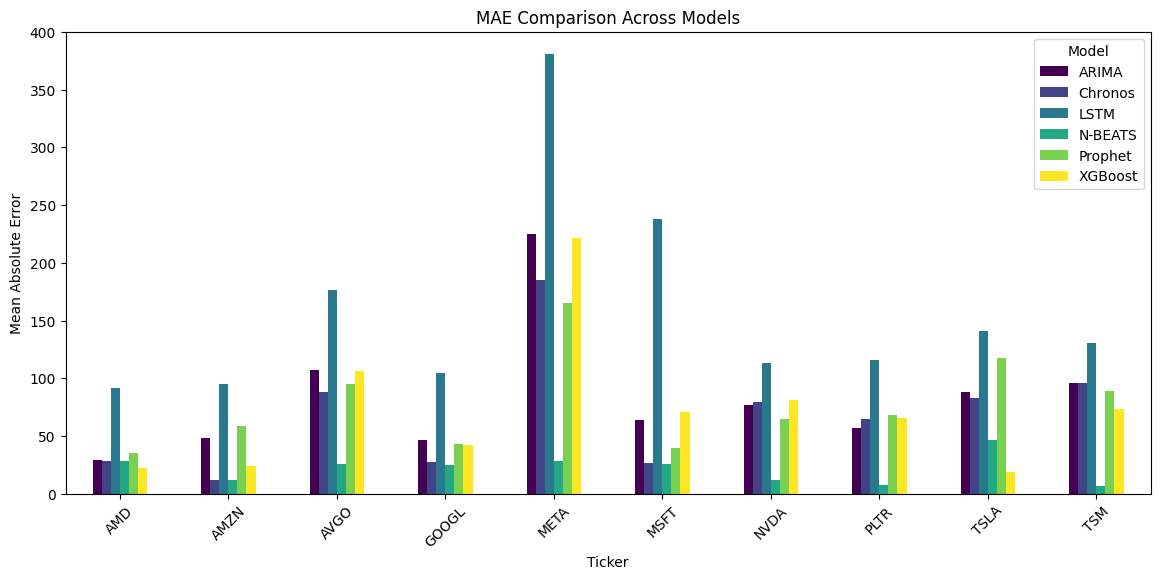

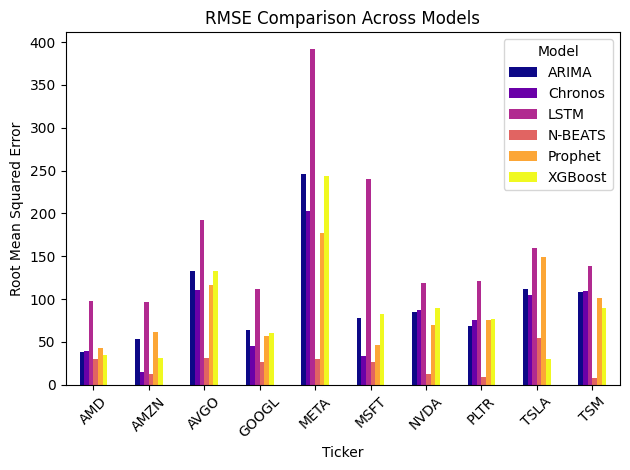


📊 Comparison Chart Saved: model_comparison.png


In [12]:
# Create Comparison DataFrame
results_df = pd.DataFrame(results)
print(results_df)

# Plot 1: MAE Comparison
plt.figure(figsize=(14, 6))
pivot_mae = results_df.pivot(index='Ticker', columns='Model', values='MAE')
pivot_mae.plot(kind='bar', ax=plt.gca(), colormap='viridis')
plt.title('MAE Comparison Across Models')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Ticker')
plt.legend(title='Model')
plt.xticks(rotation=45)
plt.show()
# Plot 2: RMSE Comparison
pivot_rmse = results_df.pivot(index='Ticker', columns='Model', values='RMSE')
pivot_rmse.plot(kind='bar', ax=plt.gca(), colormap='plasma')
plt.title('RMSE Comparison Across Models')
plt.ylabel('Root Mean Squared Error')
plt.xlabel('Ticker')
plt.legend(title='Model')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150)
plt.show()

print("\n📊 Comparison Chart Saved: model_comparison.png")

# Train Best Model for All Assets

In [24]:
import pickle
import os
# Set GCS Credentials
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = r'H:\coding\gcp_credentials.json'
print(f"✅ GCS Auth configured: {os.environ.get('GOOGLE_APPLICATION_CREDENTIALS')}")
# Create directory for models
os.makedirs('models', exist_ok=True)
def train_nbeats_production(ticker):
    """Train N-BEATS for production deployment"""
    print(f"\n{'='*60}\n🚀 PRODUCTION TRAINING: {ticker}\n{'='*60}")
    
    # 1. Fetch Data
    df = get_ready_data(ticker)
    if df is None: 
        print(f"❌ No data for {ticker}")
        return
    
    # 2. Prepare for NeuralForecast
    nf_df = df.reset_index()[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})
    nf_df['unique_id'] = ticker
    nf_df = nf_df[['unique_id', 'ds', 'y']]
    
    # 3. Define forecast horizon
    horizon = 30
    
    try:
        # 4. Initialize WandB Run
        run = wandb.init(
            project="stock-forecasting", 
            name=f"{ticker}_NBEATS_Production",
            config={
                "model": "N-BEATS",
                "ticker": ticker,
                "horizon": horizon,
                "input_size": 60,
                "max_steps": 100
            },
            reinit=True
        )
        
        # 5. Train N-BEATS (FIXED: Removed problematic loss parameter)
        print(f"⏳ Training N-BEATS for {ticker}...")
        models = [NBEATS(
            input_size=60,
            h=horizon,
            max_steps=100
            # Let it use default loss (MSE)
        )]
        
        nf = NeuralForecast(models=models, freq='D')
        
        # Split
        train_data = nf_df[:-horizon]
        test_data = nf_df[-horizon:]
        
        nf.fit(df=train_data)
        
        # 6. Evaluate
        forecast = nf.predict()
        actual = test_data['y'].values
        predicted = forecast['NBEATS'].values
        
        mae = mean_absolute_error(actual, predicted)
        rmse = np.sqrt(mean_squared_error(actual, predicted))
        
        print(f"✅ {ticker} → MAE: {mae:.2f}, RMSE: {rmse:.2f}")
        
        # 7. Log to WandB
        wandb.log({"MAE": mae, "RMSE": rmse})
        
        # 8. Save Model
        model_path = f"models/{ticker}_nbeats.pkl"
        with open(model_path, 'wb') as f:
            pickle.dump(nf, f)
        print(f"💾 Model saved: {model_path}")
        
        # 9. Log to MLFlow
        with mlflow.start_run(run_name=f"{ticker}_NBEATS_Prod"):
            mlflow.log_metric("MAE", mae)
            mlflow.log_metric("RMSE", rmse)
            mlflow.log_param("model", "N-BEATS")
            mlflow.log_param("ticker", ticker)
            mlflow.log_artifact(model_path)
        
        print(f"📊 Logged to MLFlow")
        run.finish()
        
        return {"ticker": ticker, "mae": mae, "rmse": rmse, "model_path": model_path}
        
    except Exception as e:
        print(f"❌ Error training {ticker}: {e}")
        import traceback
        traceback.print_exc()
        if 'run' in locals():
            run.finish()
        return None

# ========== PRODUCTION TRAINING LOOP ==========
print("\n" + "="*70)
print("🏭 PRODUCTION MODEL TRAINING - N-BEATS ONLY")
print("="*70 + "\n")

all_tickers = ['NVDA', 'MSFT', 'GOOGL', 'META', 'AMZN', 'AMD', 'TSM', 'AVGO', 'PLTR', 'TSLA']
production_results = []

for ticker in all_tickers:
    result = train_nbeats_production(ticker)
    if result:
        production_results.append(result)

# ========== SUMMARY TABLE ==========
print("\n" + "="*70)
print("📊 PRODUCTION TRAINING SUMMARY")
print("="*70 + "\n")

summary_df = pd.DataFrame(production_results)
print(summary_df.to_string(index=False))
print(f"\n✅ Total models trained: {len(production_results)}")
print(f"📁 Models saved in: ./models/")
print(f"☁️  Models registered in MLFlow: {MLFLOW_TRACKING_URI}")


✅ GCS Auth configured: H:\coding\gcp_credentials.json

🏭 PRODUCTION MODEL TRAINING - N-BEATS ONLY


🚀 PRODUCTION TRAINING: NVDA
📥 Fetching NVDA...


Seed set to 1


⏳ Training N-BEATS for NVDA...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE           │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm  │      0 │ train │     0 │
│ 3 │ blocks       │ ModuleList    │  2.6 M │ train │     0 │
└───┴──────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 2.6 M                                                                                            
Non-trainable params: 5.5 K                                                                                        
Total params: 2.6 M                                                                                                
Total estimated model params size (MB): 10                                                                         
Modules in train mode: 31                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_steps=100` reached.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

✅ NVDA → MAE: 9.52, RMSE: 10.89
💾 Model saved: models/NVDA_nbeats.pkl
🏃 View run NVDA_NBEATS_Prod at: http://35.192.146.116:5000/#/experiments/4/runs/979ea2cbe5a4418584c486bcd6898e87
🧪 View experiment at: http://35.192.146.116:5000/#/experiments/4
📊 Logged to MLFlow


MAE,▁
RMSE,▁
MAE,9.51621
RMSE,10.89246



🚀 PRODUCTION TRAINING: MSFT
📥 Fetching MSFT...


Seed set to 1


⏳ Training N-BEATS for MSFT...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE           │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm  │      0 │ train │     0 │
│ 3 │ blocks       │ ModuleList    │  2.6 M │ train │     0 │
└───┴──────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 2.6 M                                                                                            
Non-trainable params: 5.5 K                                                                                        
Total params: 2.6 M                                                                                                
Total estimated model params size (MB): 10                                                                         
Modules in train mode: 31                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_steps=100` reached.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

✅ MSFT → MAE: 23.76, RMSE: 24.94
💾 Model saved: models/MSFT_nbeats.pkl
🏃 View run MSFT_NBEATS_Prod at: http://35.192.146.116:5000/#/experiments/4/runs/a44b2cf9ab3f467c906851203977f5f7
🧪 View experiment at: http://35.192.146.116:5000/#/experiments/4
📊 Logged to MLFlow


MAE,▁
RMSE,▁
MAE,23.76341
RMSE,24.94313



🚀 PRODUCTION TRAINING: GOOGL
📥 Fetching GOOGL...


Seed set to 1


⏳ Training N-BEATS for GOOGL...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE           │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm  │      0 │ train │     0 │
│ 3 │ blocks       │ ModuleList    │  2.6 M │ train │     0 │
└───┴──────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 2.6 M                                                                                            
Non-trainable params: 5.5 K                                                                                        
Total params: 2.6 M                                                                                                
Total estimated model params size (MB): 10                                                                         
Modules in train mode: 31                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_steps=100` reached.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

✅ GOOGL → MAE: 22.27, RMSE: 24.86
💾 Model saved: models/GOOGL_nbeats.pkl
🏃 View run GOOGL_NBEATS_Prod at: http://35.192.146.116:5000/#/experiments/4/runs/b69bc9336e514a959c4a0903854f6579
🧪 View experiment at: http://35.192.146.116:5000/#/experiments/4
📊 Logged to MLFlow


MAE,▁
RMSE,▁
MAE,22.26681
RMSE,24.86359



🚀 PRODUCTION TRAINING: META
📥 Fetching META...


Seed set to 1


⏳ Training N-BEATS for META...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE           │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm  │      0 │ train │     0 │
│ 3 │ blocks       │ ModuleList    │  2.6 M │ train │     0 │
└───┴──────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 2.6 M                                                                                            
Non-trainable params: 5.5 K                                                                                        
Total params: 2.6 M                                                                                                
Total estimated model params size (MB): 10                                                                         
Modules in train mode: 31                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_steps=100` reached.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

✅ META → MAE: 35.11, RMSE: 38.54
💾 Model saved: models/META_nbeats.pkl
🏃 View run META_NBEATS_Prod at: http://35.192.146.116:5000/#/experiments/4/runs/4dfec341f7574c2795058f1d6b706dca
🧪 View experiment at: http://35.192.146.116:5000/#/experiments/4
📊 Logged to MLFlow


MAE,▁
RMSE,▁
MAE,35.1073
RMSE,38.53596



🚀 PRODUCTION TRAINING: AMZN
📥 Fetching AMZN...


Seed set to 1


⏳ Training N-BEATS for AMZN...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE           │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm  │      0 │ train │     0 │
│ 3 │ blocks       │ ModuleList    │  2.6 M │ train │     0 │
└───┴──────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 2.6 M                                                                                            
Non-trainable params: 5.5 K                                                                                        
Total params: 2.6 M                                                                                                
Total estimated model params size (MB): 10                                                                         
Modules in train mode: 31                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_steps=100` reached.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

✅ AMZN → MAE: 9.17, RMSE: 10.38
💾 Model saved: models/AMZN_nbeats.pkl
🏃 View run AMZN_NBEATS_Prod at: http://35.192.146.116:5000/#/experiments/4/runs/ab80285f09a94580aca2902aa5982ab5
🧪 View experiment at: http://35.192.146.116:5000/#/experiments/4
📊 Logged to MLFlow


MAE,▁
RMSE,▁
MAE,9.17134
RMSE,10.38042



🚀 PRODUCTION TRAINING: AMD
📥 Fetching AMD...


Seed set to 1


⏳ Training N-BEATS for AMD...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE           │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm  │      0 │ train │     0 │
│ 3 │ blocks       │ ModuleList    │  2.6 M │ train │     0 │
└───┴──────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 2.6 M                                                                                            
Non-trainable params: 5.5 K                                                                                        
Total params: 2.6 M                                                                                                
Total estimated model params size (MB): 10                                                                         
Modules in train mode: 31                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_steps=100` reached.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

✅ AMD → MAE: 24.94, RMSE: 26.47
💾 Model saved: models/AMD_nbeats.pkl
🏃 View run AMD_NBEATS_Prod at: http://35.192.146.116:5000/#/experiments/4/runs/78ef999d91754163b57116fe03c6394d
🧪 View experiment at: http://35.192.146.116:5000/#/experiments/4
📊 Logged to MLFlow


MAE,▁
RMSE,▁
MAE,24.94142
RMSE,26.47171



🚀 PRODUCTION TRAINING: TSM
📥 Fetching TSM...


Seed set to 1


⏳ Training N-BEATS for TSM...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE           │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm  │      0 │ train │     0 │
│ 3 │ blocks       │ ModuleList    │  2.6 M │ train │     0 │
└───┴──────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 2.6 M                                                                                            
Non-trainable params: 5.5 K                                                                                        
Total params: 2.6 M                                                                                                
Total estimated model params size (MB): 10                                                                         
Modules in train mode: 31                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_steps=100` reached.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

✅ TSM → MAE: 5.65, RMSE: 7.25
💾 Model saved: models/TSM_nbeats.pkl
🏃 View run TSM_NBEATS_Prod at: http://35.192.146.116:5000/#/experiments/4/runs/171969f4698a49718f28f48409b83c61
🧪 View experiment at: http://35.192.146.116:5000/#/experiments/4
📊 Logged to MLFlow


MAE,▁
RMSE,▁
MAE,5.64664
RMSE,7.25131



🚀 PRODUCTION TRAINING: AVGO
📥 Fetching AVGO...


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


⏳ Training N-BEATS for AVGO...


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE           │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm  │      0 │ train │     0 │
│ 3 │ blocks       │ ModuleList    │  2.6 M │ train │     0 │
└───┴──────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 2.6 M                                                                                            
Non-trainable params: 5.5 K                                                                                        
Total params: 2.6 M                                                                                                
Total estimated model params size (MB): 10                                                                         
Modules in train mode: 31                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_steps=100` reached.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

✅ AVGO → MAE: 24.44, RMSE: 28.56
💾 Model saved: models/AVGO_nbeats.pkl
🏃 View run AVGO_NBEATS_Prod at: http://35.192.146.116:5000/#/experiments/4/runs/875cc9b805ca441f8f373d1f9fabce51
🧪 View experiment at: http://35.192.146.116:5000/#/experiments/4
📊 Logged to MLFlow


MAE,▁
RMSE,▁
MAE,24.43908
RMSE,28.55944



🚀 PRODUCTION TRAINING: PLTR
📥 Fetching PLTR...


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


⏳ Training N-BEATS for PLTR...


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE           │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm  │      0 │ train │     0 │
│ 3 │ blocks       │ ModuleList    │  2.6 M │ train │     0 │
└───┴──────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 2.6 M                                                                                            
Non-trainable params: 5.5 K                                                                                        
Total params: 2.6 M                                                                                                
Total estimated model params size (MB): 10                                                                         
Modules in train mode: 31                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_steps=100` reached.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

✅ PLTR → MAE: 9.97, RMSE: 11.35
💾 Model saved: models/PLTR_nbeats.pkl
🏃 View run PLTR_NBEATS_Prod at: http://35.192.146.116:5000/#/experiments/4/runs/bd0d325ab3714ea9b7f87ee20161dc4a
🧪 View experiment at: http://35.192.146.116:5000/#/experiments/4
📊 Logged to MLFlow


MAE,▁
RMSE,▁
MAE,9.97464
RMSE,11.35266



🚀 PRODUCTION TRAINING: TSLA
📥 Fetching TSLA...


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


⏳ Training N-BEATS for TSLA...


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE           │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm  │      0 │ train │     0 │
│ 3 │ blocks       │ ModuleList    │  2.6 M │ train │     0 │
└───┴──────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 2.6 M                                                                                            
Non-trainable params: 5.5 K                                                                                        
Total params: 2.6 M                                                                                                
Total estimated model params size (MB): 10                                                                         
Modules in train mode: 31                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_steps=100` reached.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

✅ TSLA → MAE: 46.28, RMSE: 54.47
💾 Model saved: models/TSLA_nbeats.pkl
🏃 View run TSLA_NBEATS_Prod at: http://35.192.146.116:5000/#/experiments/4/runs/c1f7c3a9a3324c6b911c70d88799fa4d
🧪 View experiment at: http://35.192.146.116:5000/#/experiments/4
📊 Logged to MLFlow


MAE,▁
RMSE,▁
MAE,46.28022
RMSE,54.46783



📊 PRODUCTION TRAINING SUMMARY

ticker       mae      rmse              model_path
  NVDA  9.516209 10.892463  models/NVDA_nbeats.pkl
  MSFT 23.763413 24.943127  models/MSFT_nbeats.pkl
 GOOGL 22.266808 24.863594 models/GOOGL_nbeats.pkl
  META 35.107298 38.535958  models/META_nbeats.pkl
  AMZN  9.171340 10.380423  models/AMZN_nbeats.pkl
   AMD 24.941422 26.471707   models/AMD_nbeats.pkl
   TSM  5.646644  7.251311   models/TSM_nbeats.pkl
  AVGO 24.439078 28.559442  models/AVGO_nbeats.pkl
  PLTR  9.974639 11.352657  models/PLTR_nbeats.pkl
  TSLA 46.280220 54.467830  models/TSLA_nbeats.pkl

✅ Total models trained: 10
📁 Models saved in: ./models/
☁️  Models registered in MLFlow: http://35.192.146.116:5000



📊 N-BEATS PERFORMANCE COMPARISON (10 Tickers)

ticker       mae      rmse              model_path
   TSM  5.646644  7.251311   models/TSM_nbeats.pkl
  AMZN  9.171340 10.380423  models/AMZN_nbeats.pkl
  NVDA  9.516209 10.892463  models/NVDA_nbeats.pkl
  PLTR  9.974639 11.352657  models/PLTR_nbeats.pkl
 GOOGL 22.266808 24.863594 models/GOOGL_nbeats.pkl
  MSFT 23.763413 24.943127  models/MSFT_nbeats.pkl
  AVGO 24.439078 28.559442  models/AVGO_nbeats.pkl
   AMD 24.941422 26.471707   models/AMD_nbeats.pkl
  META 35.107298 38.535958  models/META_nbeats.pkl
  TSLA 46.280220 54.467830  models/TSLA_nbeats.pkl

🏆 Best Model: TSM (MAE: 5.65)
⚠️  Worst Model: TSLA (MAE: 46.28)


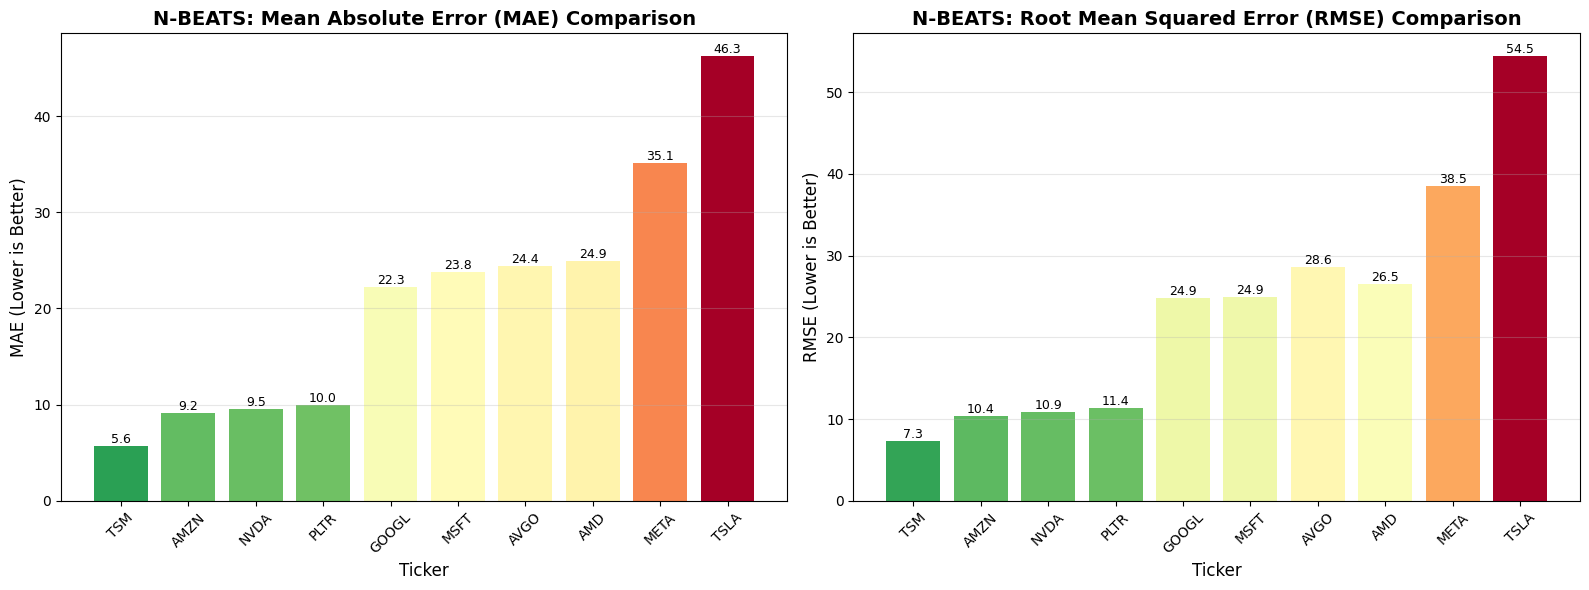


✅ Visualization saved: nbeats_comparison.png

📈 SUMMARY STATISTICS
Average MAE:  21.11
Average RMSE: 23.77
Std Dev MAE:  12.93
Std Dev RMSE: 14.78


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ========== VISUALIZATION: N-BEATS MODEL COMPARISON ==========

# Assuming production_results is already populated from previous training
if not production_results:
    print("⚠️  No results found. Make sure to run the training loop first!")
else:
    # Convert to DataFrame
    nbeats_df = pd.DataFrame(production_results)
    nbeats_df = nbeats_df.sort_values('mae')  # Sort by MAE (best to worst)
    
    print("\n" + "="*70)
    print("📊 N-BEATS PERFORMANCE COMPARISON (10 Tickers)")
    print("="*70 + "\n")
    print(nbeats_df.to_string(index=False))
    print(f"\n🏆 Best Model: {nbeats_df.iloc[0]['ticker']} (MAE: {nbeats_df.iloc[0]['mae']:.2f})")
    print(f"⚠️  Worst Model: {nbeats_df.iloc[-1]['ticker']} (MAE: {nbeats_df.iloc[-1]['mae']:.2f})")
    
    # ========== PLOT 1: MAE Comparison ==========
    plt.figure(figsize=(16, 6))
    
    plt.subplot(1, 2, 1)
    bars1 = plt.bar(nbeats_df['ticker'], nbeats_df['mae'], 
                    color=plt.cm.RdYlGn_r(nbeats_df['mae'] / nbeats_df['mae'].max()))
    plt.title('N-BEATS: Mean Absolute Error (MAE) Comparison', fontsize=14, fontweight='bold')
    plt.xlabel('Ticker', fontsize=12)
    plt.ylabel('MAE (Lower is Better)', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom', fontsize=9)
    
    # ========== PLOT 2: RMSE Comparison ==========
    plt.subplot(1, 2, 2)
    bars2 = plt.bar(nbeats_df['ticker'], nbeats_df['rmse'],
                    color=plt.cm.RdYlGn_r(nbeats_df['rmse'] / nbeats_df['rmse'].max()))
    plt.title('N-BEATS: Root Mean Squared Error (RMSE) Comparison', fontsize=14, fontweight='bold')
    plt.xlabel('Ticker', fontsize=12)
    plt.ylabel('RMSE (Lower is Better)', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars2:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('nbeats_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n✅ Visualization saved: nbeats_comparison.png")
    
    # ========== STATISTICS SUMMARY ==========
    print("\n" + "="*70)
    print("📈 SUMMARY STATISTICS")
    print("="*70)
    print(f"Average MAE:  {nbeats_df['mae'].mean():.2f}")
    print(f"Average RMSE: {nbeats_df['rmse'].mean():.2f}")
    print(f"Std Dev MAE:  {nbeats_df['mae'].std():.2f}")
    print(f"Std Dev RMSE: {nbeats_df['rmse'].std():.2f}")

# Model Testing


📊 Generating plot for NVDA...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

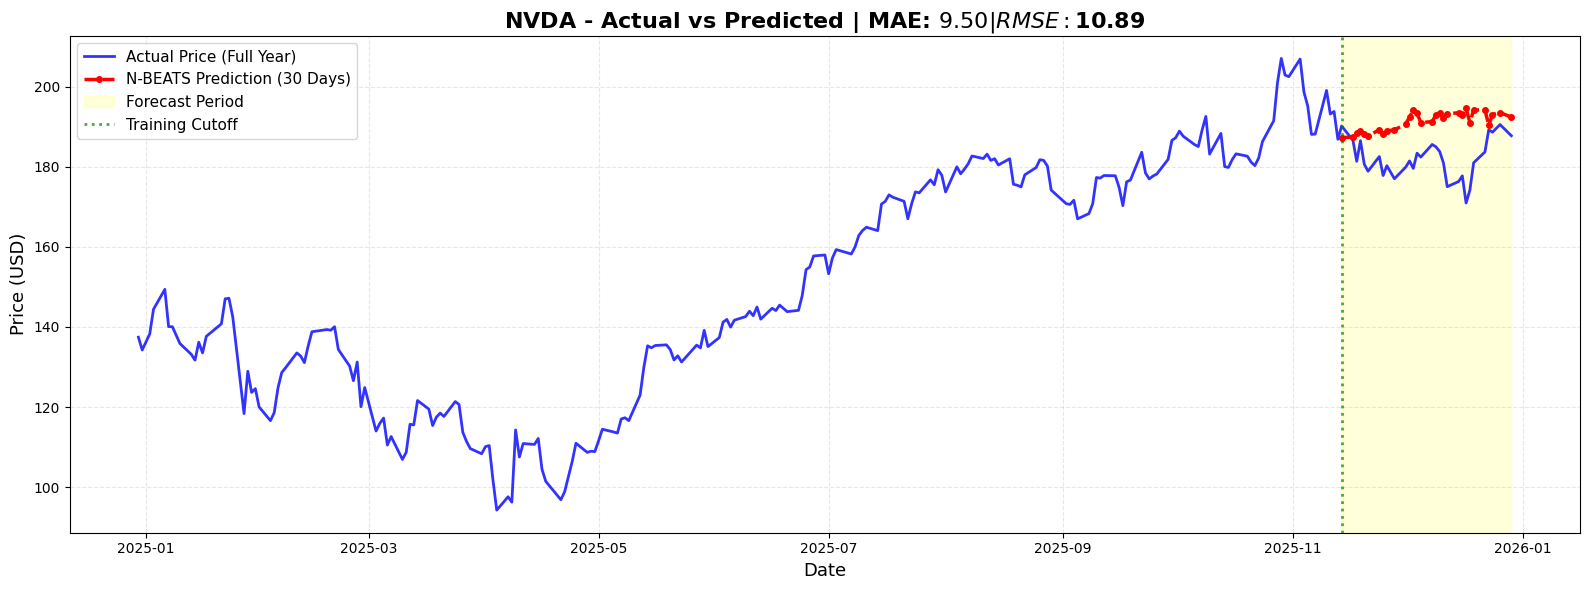

✅ NVDA → MAE: $9.50, RMSE: $10.89

📊 Generating plot for MSFT...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

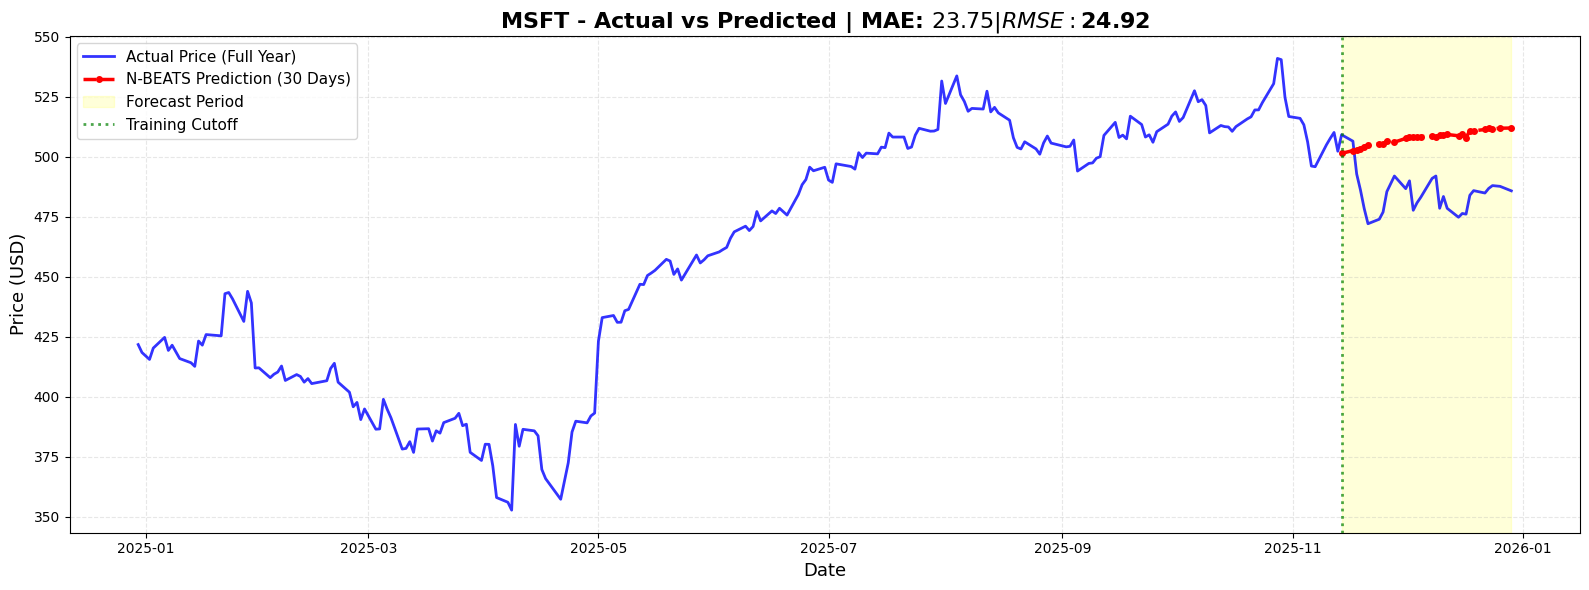

GPU available: True (cuda), used: True


✅ MSFT → MAE: $23.75, RMSE: $24.92

📊 Generating plot for GOOGL...


TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

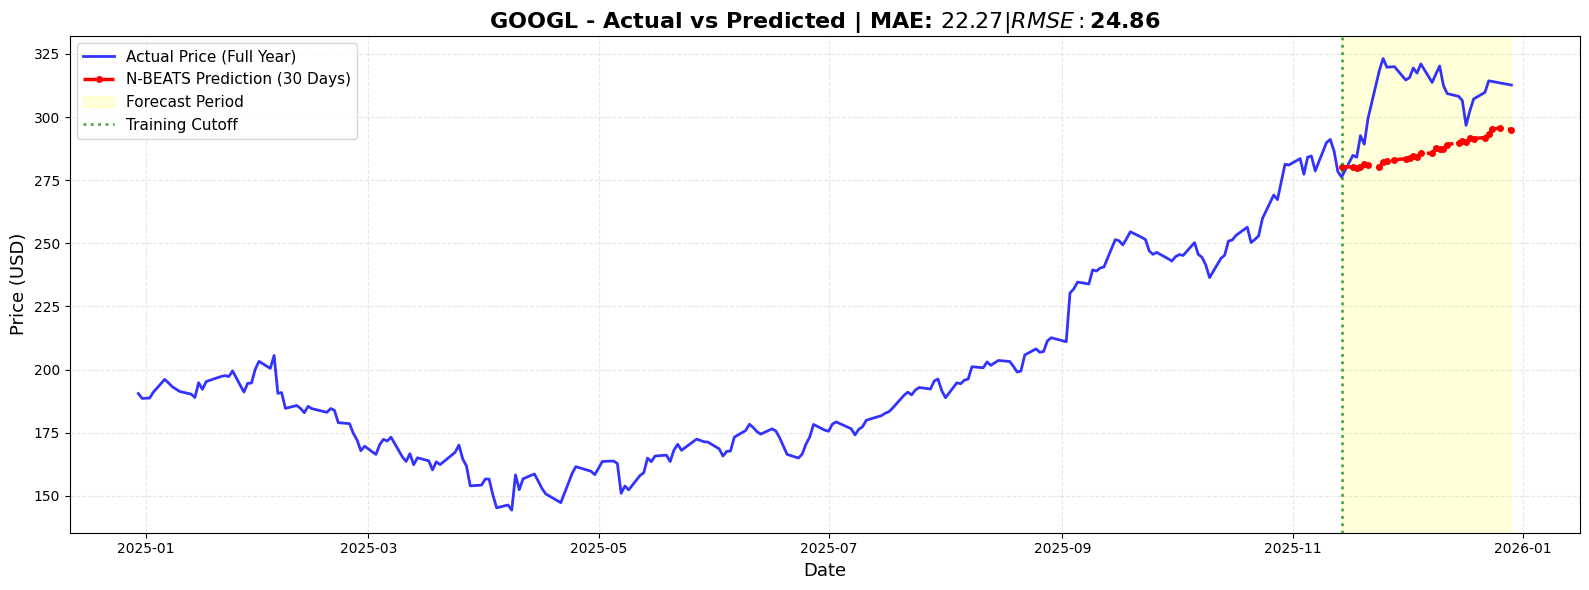

✅ GOOGL → MAE: $22.27, RMSE: $24.86

📊 Generating plot for META...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

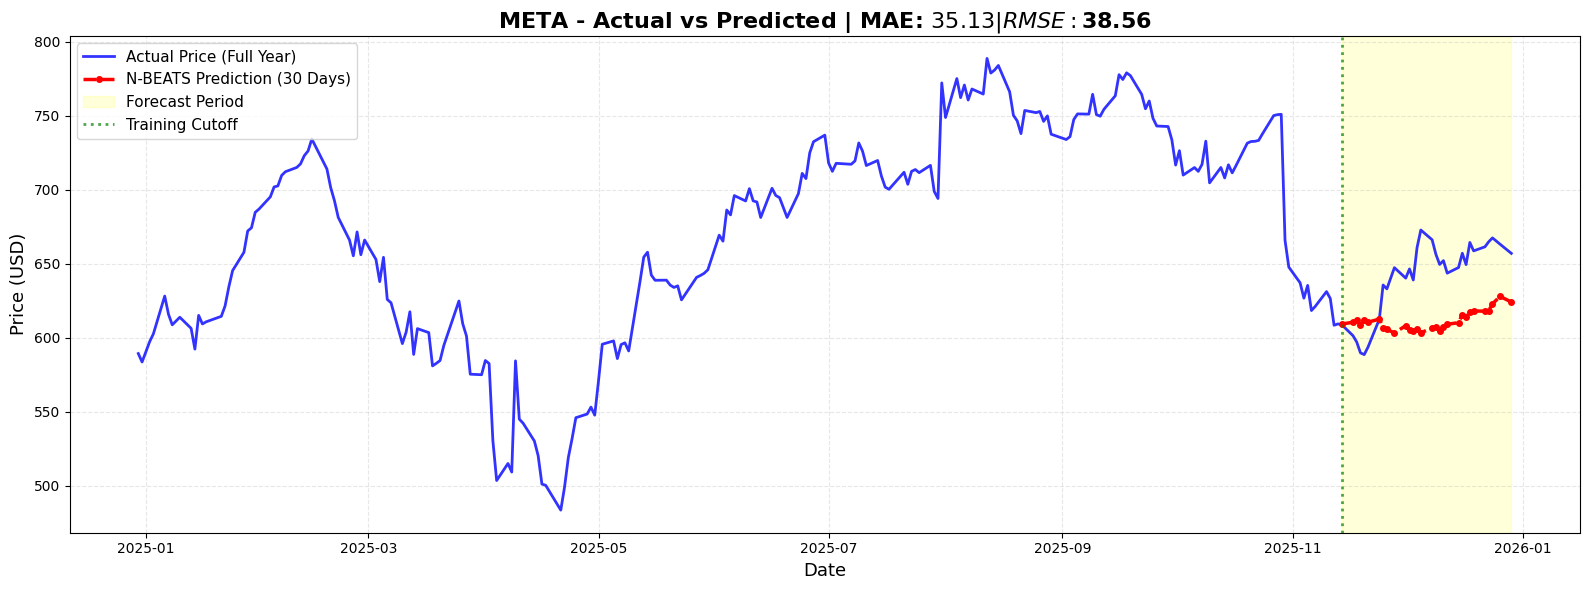

✅ META → MAE: $35.13, RMSE: $38.56

📊 Generating plot for AMZN...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

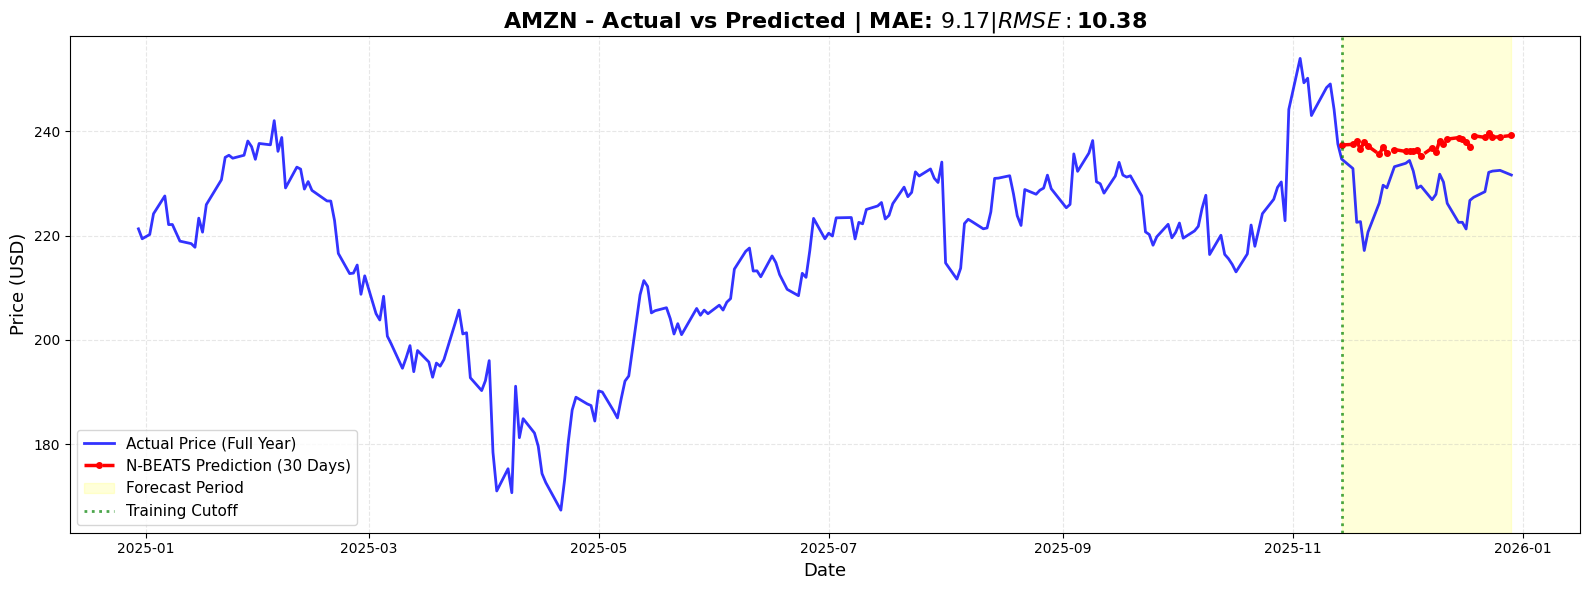

✅ AMZN → MAE: $9.17, RMSE: $10.38

📊 Generating plot for AMD...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

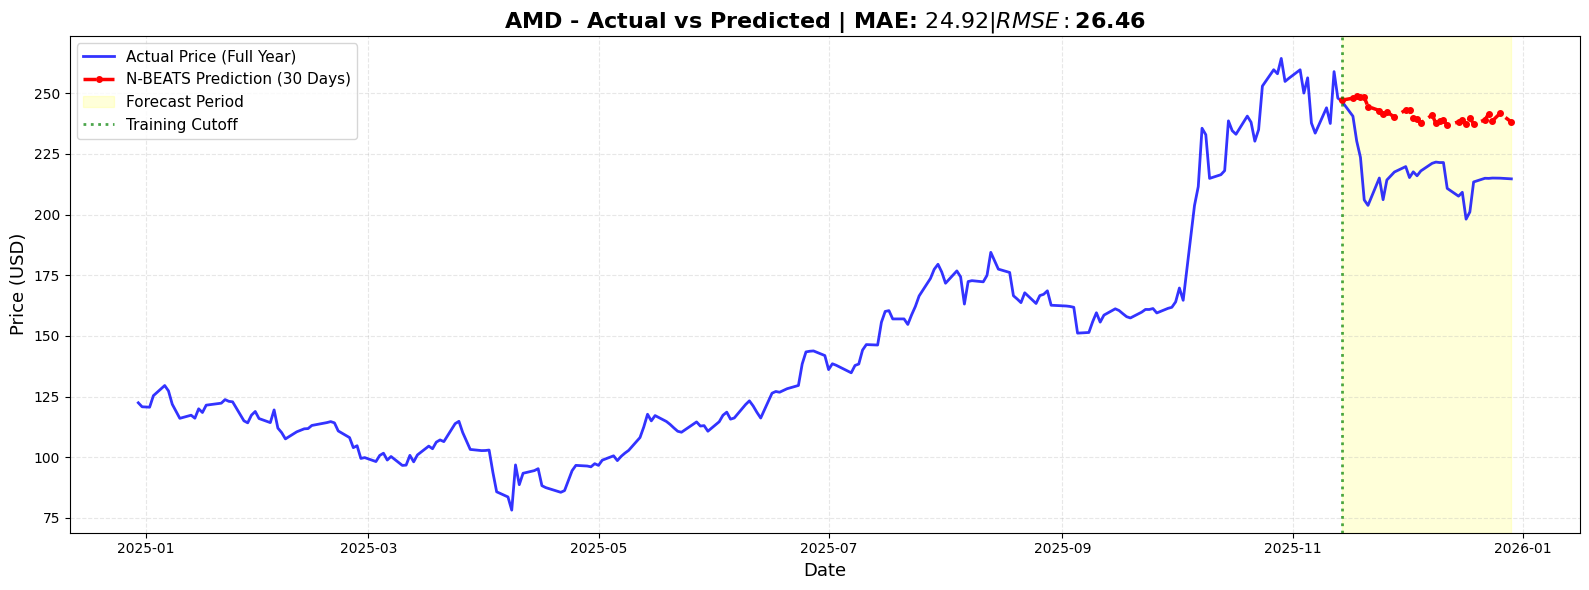

✅ AMD → MAE: $24.92, RMSE: $26.46

📊 Generating plot for TSM...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

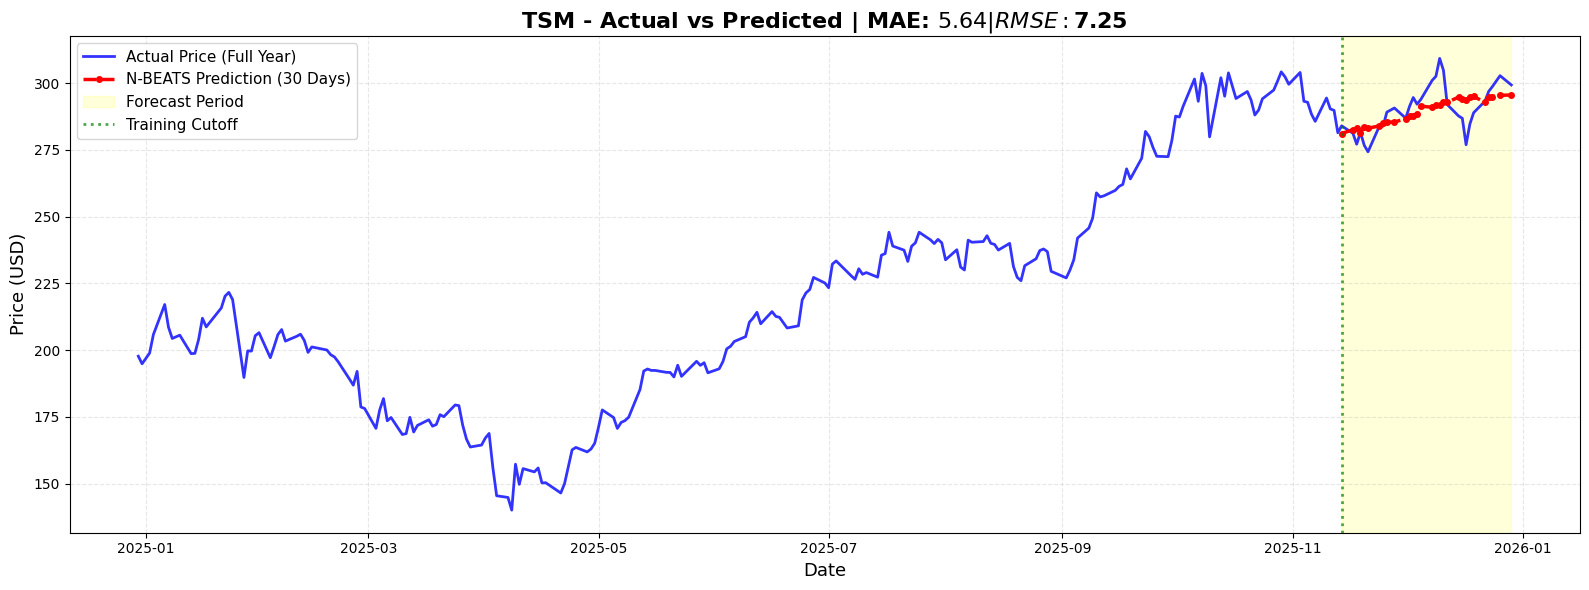

✅ TSM → MAE: $5.64, RMSE: $7.25

📊 Generating plot for AVGO...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

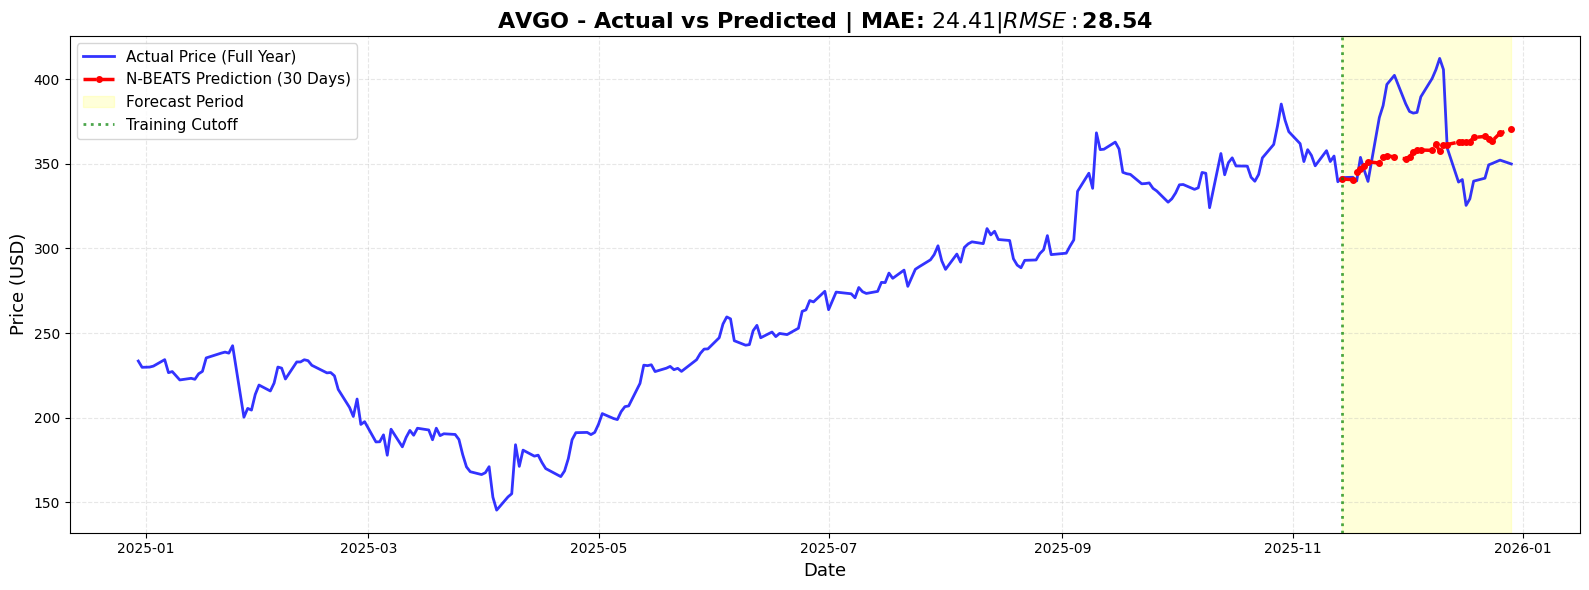

✅ AVGO → MAE: $24.41, RMSE: $28.54

📊 Generating plot for PLTR...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

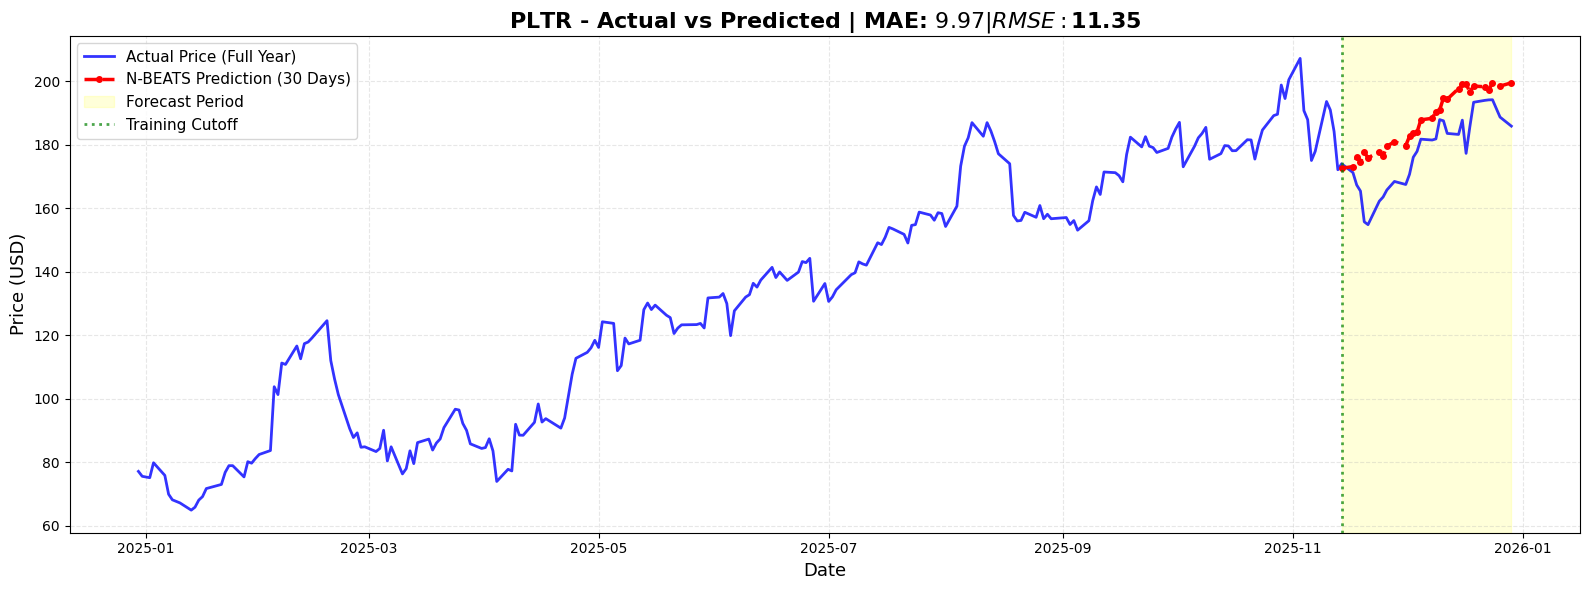

✅ PLTR → MAE: $9.97, RMSE: $11.35

📊 Generating plot for TSLA...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

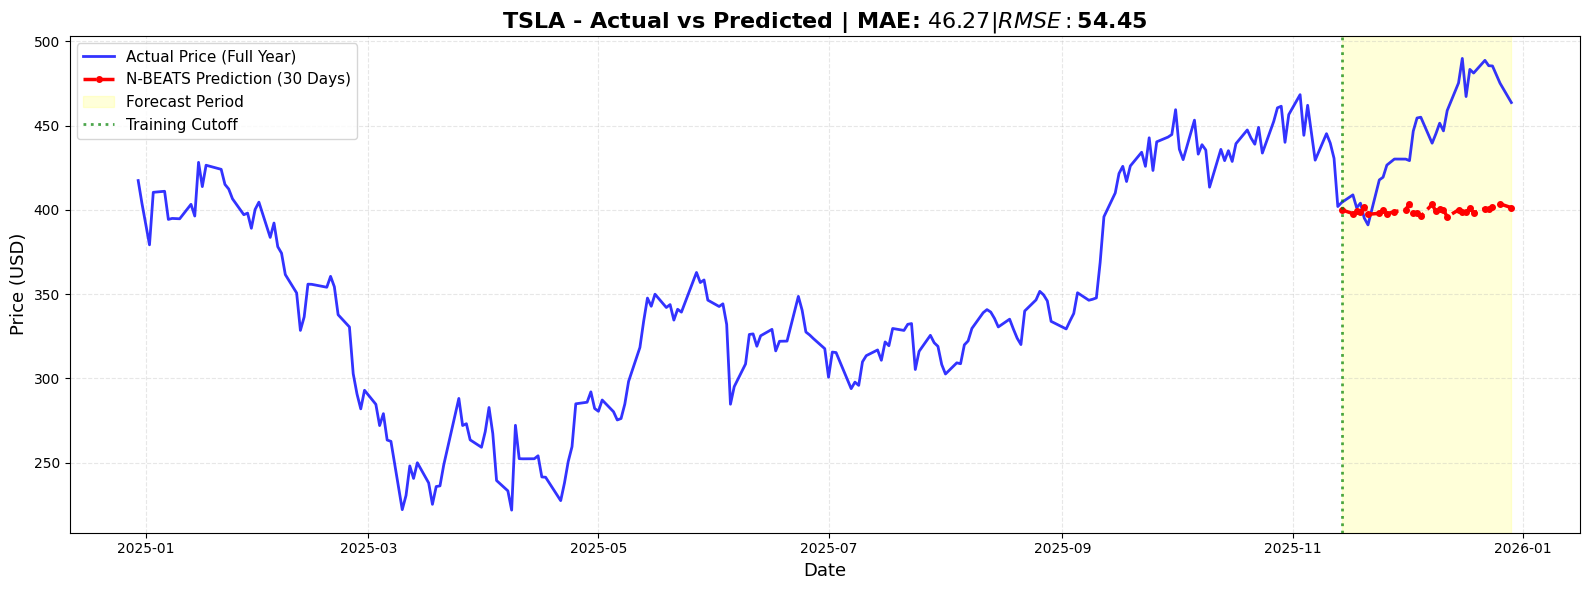

✅ TSLA → MAE: $46.27, RMSE: $54.45

📊 VALIDATION SUMMARY (30-Day Forecast)
ticker       mae      rmse
   TSM  5.643977  7.249909
  AMZN  9.172447 10.381230
  NVDA  9.500376 10.885377
  PLTR  9.973386 11.351151
 GOOGL 22.268435 24.864748
  MSFT 23.745414 24.924017
  AVGO 24.410577 28.538534
   AMD 24.923225 26.455407
  META 35.134135 38.558571
  TSLA 46.267253 54.452932


In [29]:
import matplotlib.pyplot as plt
import pickle

# ========== INDIVIDUAL PLOT: ACTUAL vs PREDICTED (Per Ticker) ==========

validation_results = []

for ticker in all_tickers:
    print(f"\n📊 Generating plot for {ticker}...")
    
    # Load model
    model_path = f"models/{ticker}_nbeats.pkl"
    if not os.path.exists(model_path):
        print(f"❌ Model not found: {model_path}")
        continue
    
    with open(model_path, 'rb') as f:
        nf_model = pickle.load(f)
    
    # Fetch 1 year data
    df_full = yf.download(ticker, period='1y', interval='1d', auto_adjust=True, progress=False)
    if isinstance(df_full.columns, pd.MultiIndex):
        df_full.columns = df_full.columns.get_level_values(0)
    
    if df_full.empty:
        print(f"❌ No data for {ticker}")
        continue
    
    # Prepare NeuralForecast format
    nf_df = df_full.reset_index()[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})
    nf_df['unique_id'] = ticker
    nf_df = nf_df[['unique_id', 'ds', 'y']]
    
    # FIXED: Split for 30 days (matching horizon)
    train_size = len(nf_df) - 30  # Last 30 days for testing (matches horizon=30)
    train_data = nf_df[:train_size]
    test_data = nf_df[train_size:]
    
    # Predict
    try:
        forecast = nf_model.predict(df=train_data)
        predicted_values = forecast['NBEATS'].values[:30]  # Take only 30 day forecast
        
        # Calculate metrics
        actual_test = test_data['y'].values
        mae = mean_absolute_error(actual_test, predicted_values)
        rmse = np.sqrt(mean_squared_error(actual_test, predicted_values))
        
        # Create plot
        plt.figure(figsize=(16, 6))
        
        # Full year actual data
        plt.plot(nf_df['ds'], nf_df['y'], 
                label='Actual Price (Full Year)', 
                color='blue', linewidth=2, alpha=0.8)
        
        # Predicted last 30 days
        plt.plot(test_data['ds'], predicted_values, 
                label='N-BEATS Prediction (30 Days)', 
                color='red', linewidth=2.5, linestyle='--', marker='o', markersize=4)
        
        # Highlight test period
        plt.axvspan(test_data['ds'].iloc[0], test_data['ds'].iloc[-1], 
                    alpha=0.15, color='yellow', label='Forecast Period')
        
        # Vertical line at cutoff
        plt.axvline(x=test_data['ds'].iloc[0], color='green', linestyle=':', 
                   linewidth=2, label='Training Cutoff', alpha=0.7)
        
        plt.title(f'{ticker} - Actual vs Predicted | MAE: ${mae:.2f} | RMSE: ${rmse:.2f}', 
                 fontsize=16, fontweight='bold')
        plt.xlabel('Date', fontsize=13)
        plt.ylabel('Price (USD)', fontsize=13)
        plt.legend(loc='best', fontsize=11)
        plt.grid(alpha=0.3, linestyle='--')
        plt.tight_layout()
        plt.show()
        
        validation_results.append({"ticker": ticker, "mae": mae, "rmse": rmse})
        print(f"✅ {ticker} → MAE: ${mae:.2f}, RMSE: ${rmse:.2f}")
        
    except Exception as e:
        print(f"❌ Error for {ticker}: {e}")

# Summary
if validation_results:
    val_df = pd.DataFrame(validation_results).sort_values('mae')
    print("\n" + "="*60)
    print("📊 VALIDATION SUMMARY (30-Day Forecast)")
    print("="*60)
    print(val_df.to_string(index=False))